In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from torch.autograd.gradcheck import gradcheck
from torch.autograd import Variable
import os
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# from utils import plot_images

Preprocessing and loading dataset


In [2]:
#preprocessing
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#transform image data
train_set= datasets.ImageFolder(root='img/train', transform = transformations)
val_set = datasets.ImageFolder(root='img/val', transform = transformations)
test_set=datasets.ImageFolder(root='img/test', transform = transformations)

#load image data
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =64, shuffle=True)


Visualising images

In [3]:
#visualize images
def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)
    label_names=['indoor','outdoor']
    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


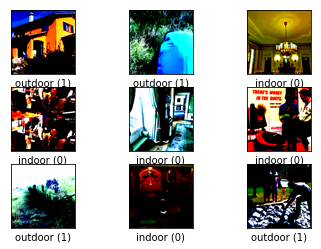

In [4]:
#create a random sub sample of data
num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(1000 * num_train))
batch_size=64
shuffle=True
if True:
    np.random.seed(20)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# visualize some images
if True:
    sample_loader = torch.utils.data.DataLoader(
        train_set, batch_size=9, shuffle=shuffle,
        
    )
    data_iter = iter(sample_loader)
    images, labels = data_iter.next()
#     print(image.size())
    X = np.transpose(images,[0, 2, 3, 1])
#     print(X.shape)
    plot_images(X, labels)



Loading model

In [5]:
#load pretrained model
model = models.vgg16(pretrained=True)

#turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

Modify model classifier

In [6]:
#modify classifier to fit binary classification
classifier = nn.Sequential(nn.Linear(25088, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))
model.classifier = classifier

Load model on device

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Set negative log likelihood loss and optimizer

In [8]:
loss_criteria = nn.NLLLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

Training the classifier

In [9]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])

epochs = 10
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # clear optimizers
        optimizer.zero_grad()
        # forward pass
        output = model.forward(inputs)
        print(output.size())
        # loss
        loss = loss_criteria(output, labels)
        # calculate gradients
        loss.backward()
        #unit test to check gradients
#       test = gradcheck(model, (input))
#         print(test)
        # adjust parameters
        optimizer.step()
        # add loss to the training set's running loss
        train_loss += loss.item()*inputs.size(0)
        
        # print the training progress 
        counter += 1
        print(counter, "/", len(train_loader),train_loss)
        
    # Evaluating the model


    model.eval()
    counter = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model.forward(inputs)

            valloss = loss_criteria(output, labels)
            val_loss += valloss.item()*inputs.size(0)

            output = torch.exp(output)
            top_p, top_class = output.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)

            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            counter += 1
            print(counter, "/", len(val_loader))

    # average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)

    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))



torch.Size([64, 2])
1 / 121 43.47749328613281
torch.Size([64, 2])
2 / 121 101.08211517333984
torch.Size([64, 2])
3 / 121 116.5110092163086
torch.Size([64, 2])
4 / 121 200.67645263671875
torch.Size([64, 2])
5 / 121 229.4967155456543
torch.Size([64, 2])
6 / 121 251.99911499023438
torch.Size([64, 2])
7 / 121 275.74220848083496
torch.Size([64, 2])
8 / 121 283.4030737876892
torch.Size([64, 2])
9 / 121 292.9931321144104
torch.Size([64, 2])
10 / 121 309.7142415046692


FileNotFoundError: [Errno 2] No such file or directory: 'img/train/outdoor/frame_00063.jpg'

Processing a single image and predicting class using model

In [ ]:
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [ ]:
def predict(image, model):
    output = model.forward(image)
    output = torch.exp(output)
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()


In [ ]:
def show_image(image):

    image = image.numpy()
    image[0] = image[0] * 0.226 + 0.445
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [ ]:
image = process_image("img/test/outdoor/out0963.jpg")
top_prob, top_class = predict(image, model)
if top_class== 0:
    top='indoor'
else:
    top='outdoor'
show_image(image)
print("Image has a predicted class of ", top)
